# W2V MLP

### Imports

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import optuna
import random
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
import time
import torch.serialization
from spacy.lang.de.stop_words import STOP_WORDS
import mlflow
import mlflow.pytorch
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
optuna.logging.set_verbosity(optuna.logging.WARNING)

torch.cuda.manual_seed_all(seed)

mlflow.set_experiment("W2V")
mlflow.pytorch.autolog()

BENCHMARK_TABLE = "../../class_bench.parquet"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data into a Dataframe (df)

In [3]:
df = pd.read_parquet("../data/de_poems.parquet")
df = df.astype(
    {"title": "string", "text": "string", "author": "string", "creation": "int64"}
)
df.dtypes


title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

In [4]:
df_siecles = df.copy()
df_siecles["creation"] = pd.to_numeric(df_siecles["creation"], errors="coerce")

mask = df_siecles["creation"].notna()
df_siecles.loc[mask, "creation"] = df_siecles.loc[mask, "creation"].apply(
    lambda x: (x - 1) // 100 + 1
)

df = df_siecles

### Tokenizing text

#### Spacy

In [14]:
nlp = spacy.load("de_core_news_sm")


def preprocess_text_spacy(doc):
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens


def preprocess_text_spacy_stopwords(doc):
    filtered_tokens = [
        token.lemma_
        for token in doc
        if not token.is_punct and token.lemma_.lower() not in STOP_WORDS
    ]
    return filtered_tokens


In [15]:
texts = df["text"].tolist()
docs = list(nlp.pipe(texts, batch_size=1000, n_process=4))

df["tokens"] = [preprocess_text_spacy_stopwords(doc) for doc in docs]

In [26]:
df.to_pickle("spacy_tokenized.pkl")

In [ ]:
df = pd.read_pickle("../../multi_layer_perceptron/spacy_tokenized.pkl")

### Training Word 2 Vec on the tokenized texts

In [ ]:
tokenized_poems = df["tokens"].tolist()
model_df = Word2Vec(tokenized_poems, vector_size=100, window=5, min_count=2, workers=4)

model_df.save("word2vec_df.model")

#### W2V Boosted

In [35]:
model_df = Word2Vec(
    sentences=df["tokens"],
    vector_size=500,
    window=20,
    min_count=2,
    workers=32,
    epochs=50,
    seed=42,
)

model_df.save("word2vec_boosted2.model")

In [5]:
model_df = Word2Vec.load("../../multi_layer_perceptron/word2vec_boosted2.model")

### Embedding Text && Encoding Century

In [ ]:
def text_to_embedding(tokens, model, embedding_dim=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

def vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size * 2)
    vectors = np.array(vectors)
    mean_vec = vectors.mean(axis=0)
    max_vec = vectors.max(axis=0)
    return np.concatenate([mean_vec, max_vec])


df["embedding"] = df["tokens"].apply(lambda x: text_to_embedding(x, model_df))
#df["embedding"] = df["tokens"].apply(lambda x: vectorize(x, model_df))

In [7]:
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
df.loc[:, "creation"] = label_encoder.fit_transform(df["creation"])

x = torch.tensor(np.stack(df["embedding"].values), dtype=torch.float32)
y = torch.tensor(df["creation"].values, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

## MLP

In [8]:
class LanguageModelNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_classes):
        super(LanguageModelNN, self).__init__()

        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class LanguageModelNN_Dropout(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(
            self.y[idx], dtype=torch.long
        )

### Creating the data loaders

In [ ]:
train_dataset = TextDataset(x_train, y_train)
val_dataset = TextDataset(x_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Creating model and hyperparameters

In [21]:
embedding_dim = 500
hidden_size = 128
num_classes = len(df["century_label"].unique())

class_counts = np.bincount(df["century_label"])
class_weights = 1.0 / class_counts

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = LanguageModelNN(embedding_dim, hidden_size, num_classes)
# model = LanguageModelNN_Dropout(num_classes)
model.apply(initialize_weights)

loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


### Training and Validating model

In [9]:
def train_mlp(model, train_loader, loss_fn, optimizer, num_epochs=10):
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f}s")
    return total_time

In [22]:
mlflow.end_run()    
mlp_training_time = train_mlp(model, train_loader, loss_fn, optimizer, num_epochs=200)

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/multi_layer_perceptron/model/mlp.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(


Epoch 1/200, Loss: 0.5604
Epoch 2/200, Loss: 0.4201
Epoch 3/200, Loss: 0.3657
Epoch 4/200, Loss: 0.3225
Epoch 5/200, Loss: 0.2863
Epoch 6/200, Loss: 0.2576
Epoch 7/200, Loss: 0.2346
Epoch 8/200, Loss: 0.2110
Epoch 9/200, Loss: 0.1923
Epoch 10/200, Loss: 0.1768
Epoch 11/200, Loss: 0.1626
Epoch 12/200, Loss: 0.1497
Epoch 13/200, Loss: 0.1384
Epoch 14/200, Loss: 0.1281
Epoch 15/200, Loss: 0.1204
Epoch 16/200, Loss: 0.1115
Epoch 17/200, Loss: 0.1032
Epoch 18/200, Loss: 0.0960
Epoch 19/200, Loss: 0.0896
Epoch 20/200, Loss: 0.0881
Epoch 21/200, Loss: 0.0801
Epoch 22/200, Loss: 0.0760
Epoch 23/200, Loss: 0.0746
Epoch 24/200, Loss: 0.0698
Epoch 25/200, Loss: 0.0659
Epoch 26/200, Loss: 0.0643
Epoch 27/200, Loss: 0.0608
Epoch 28/200, Loss: 0.0569
Epoch 29/200, Loss: 0.0597
Epoch 30/200, Loss: 0.0548
Epoch 31/200, Loss: 0.0523
Epoch 32/200, Loss: 0.0553
Epoch 33/200, Loss: 0.0499
Epoch 34/200, Loss: 0.0505
Epoch 35/200, Loss: 0.0477
Epoch 36/200, Loss: 0.0460
Epoch 37/200, Loss: 0.0483
Epoch 38/2

## Evaluation

### Evaluation for MLP Model

In [10]:
def calculate_metrics(all_labels, all_predictions, all_probs, label_encoder):
    all_labels_original = label_encoder.inverse_transform(all_labels)
    all_predictions_original = label_encoder.inverse_transform(all_predictions)
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision_avg = precision_score(all_labels, all_predictions, average="weighted")
    recall_avg = recall_score(all_labels, all_predictions, average="weighted")
    f1_score_avg = f1_score(all_labels, all_predictions, average="weighted")
    
    cm = confusion_matrix(all_labels, all_predictions, labels=label_encoder.classes_)
    cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    
    specificity = []
    for i in range(len(label_encoder.classes_)):
        tn = np.sum((all_labels != i) & (all_predictions != i))
        fp = np.sum((all_labels != i) & (all_predictions == i))
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    avg_specificity = np.mean(specificity)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(label_encoder.classes_)):
        y_true_binary = (all_labels == i).astype(int)
        y_score = all_probs[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    y_true_bin = np.zeros((len(all_labels), len(label_encoder.classes_)))
    for i in range(len(all_labels)):
        y_true_bin[i, all_labels[i]] = 1
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    avg_roc = roc_auc["micro"]
    
    return {
        'accuracy': accuracy,
        'precision': precision_avg,
        'recall': recall_avg,
        'f1': f1_score_avg,
        'specificity': avg_specificity,
        'auc': avg_roc,
        'cm': cm,
        'cm_percentage': cm_percentage,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'labels_original': all_labels_original,
        'predictions_original': all_predictions_original
    }

In [11]:
def plot_confusion_matrix(cm_percentage, label_encoder):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_percentage,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (%)")
    plt.show()

In [13]:
def plot_roc_curves(fpr, tpr, roc_auc, label_encoder, avg_roc):
    plt.figure(figsize=(10, 8))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (area = {avg_roc:.2f})",
    )

    for i in range(len(label_encoder.classes_)):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f"ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})",
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.show()

In [14]:
def print_metrics(metrics, validation_time, training_time=None):
    print("\n=== Validation Metrics ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"AUC (micro): {metrics['auc']:.4f}")
    print(f"Validation time: {validation_time:.2f}s")

    if training_time is not None:
        print(f"Training time: {training_time:.2f}s")
        print(f"Total time (train + validate): {training_time + validation_time:.2f}s")

    print("\n=== Classification Report ===")
    report = classification_report(
        metrics["labels_original"],
        metrics["predictions_original"],
        target_names=[str(c) for c in label_encoder.classes_],
    )
    print(report)

In [15]:
def validate_mlp(model, val_loader, label_encoder, training_time=None):
    model.eval()
    start_time = time.time()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    metrics = calculate_metrics(all_labels, all_predictions, all_probs, label_encoder)

    validation_time = time.time() - start_time

    print_metrics(metrics, validation_time, training_time)

    plot_confusion_matrix(metrics["cm_percentage"], label_encoder)
    plot_roc_curves(
        metrics["fpr"],
        metrics["tpr"],
        metrics["roc_auc"],
        label_encoder,
        metrics["auc"],
    )

    return (
        metrics["recall"],
        metrics["f1"],
        metrics["precision"],
        metrics["accuracy"],
        metrics["auc"],
    )


=== Validation Metrics ===
Accuracy: 0.8405
Precision: 0.8376
Recall: 0.8405
F1-Score: 0.8386
Specificity: 0.9732
AUC (micro): 0.9830
Validation time: 0.36s


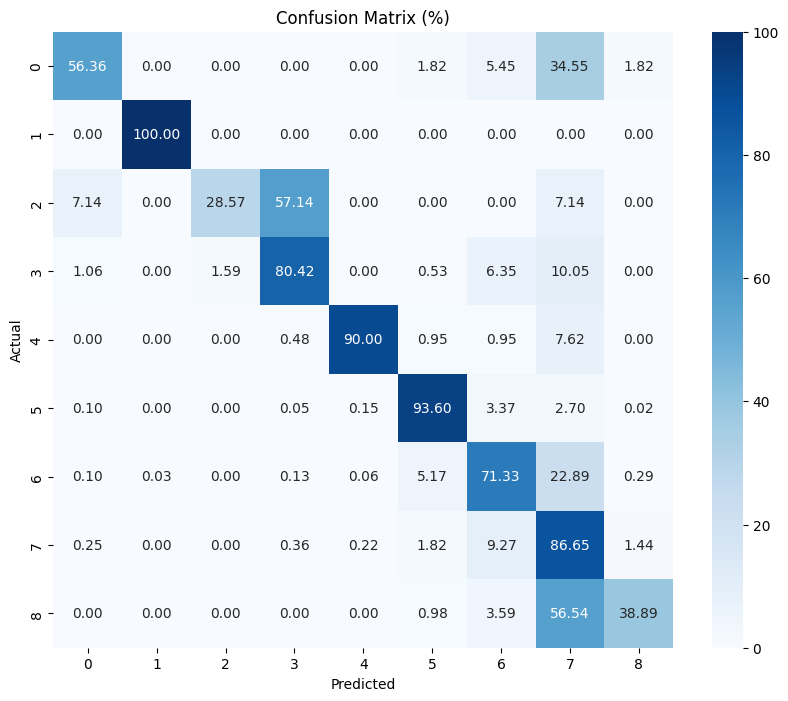

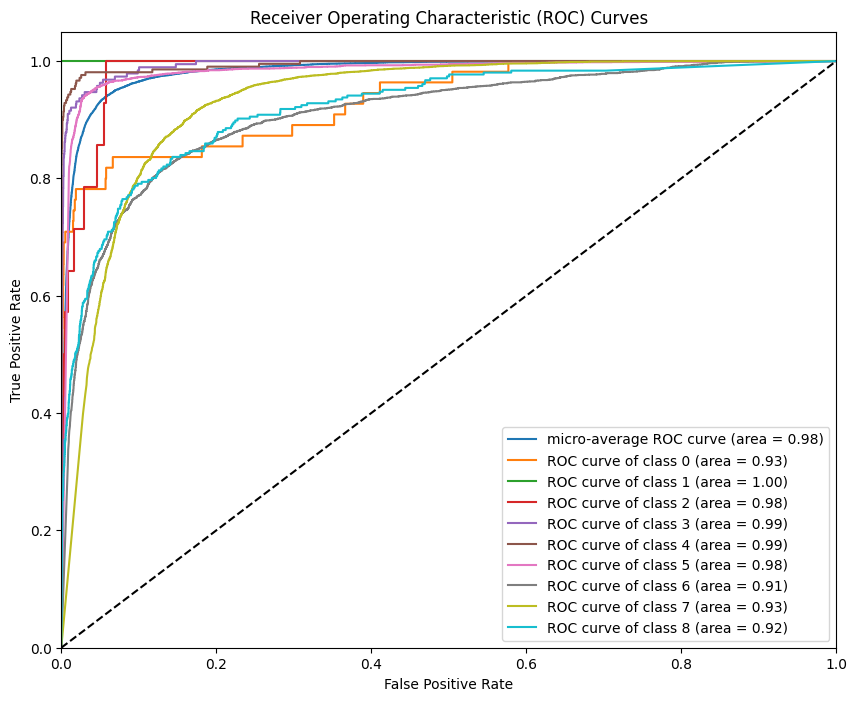


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        55
           1       0.80      1.00      0.89         4
           2       0.57      0.29      0.38        14
           3       0.80      0.80      0.80       189
           4       0.90      0.90      0.90       210
           5       0.93      0.94      0.93      4032
           6       0.75      0.71      0.73      3115
           7       0.84      0.87      0.85      6389
           8       0.54      0.39      0.45       306

    accuracy                           0.84     14314
   macro avg       0.74      0.72      0.72     14314
weighted avg       0.84      0.84      0.84     14314



In [7]:
recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc = validate_mlp(model, val_loader, label_encoder)

In [8]:
benchmark = pd.read_parquet(BENCHMARK_TABLE)

In [9]:
benchmark

Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
Word2Vec Logistic Regression         0.000000       0.000000    0.000000   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
Word2Vec Logistic Regression             0.000000  0.000000   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0

In [10]:
benchmark.loc[
    ("Word2Vec", "Multi-Layer Perceptron"),
    ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"],
] = [recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc]


In [11]:
benchmark

Accuracy  Avg Precision  Avg Recall  \
Encoding Model                                                             
TF-IDF   Logistic Regression         0.803689       0.828462    0.803689   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
Word2Vec Logistic Regression         0.000000       0.000000    0.000000   
         Feedforward Neural Network  0.000000       0.000000    0.000000   
         Recurrent Neural Network    0.000000       0.000000    0.000000   
         Naive Bayes                 0.000000       0.000000    0.000000   
         Random Forest               0.000000       0.000000    0.000000   
         Multi-Layer Perceptron      0.840506       0.837564    0.840506   

                                     Avg F1-Score   Avg AUC  \
Encoding Model                                                
TF-IDF   Logistic Regression             0.812189  0.969342   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
Word2Vec Logistic Regression             0.000000  0.000000   
         Feedforward Neural Network      0.000000  0.000000   
         Recurrent Neural Network        0.000000  0.000000   
         Naive Bayes                     0.000000  0.000000   
         Random Forest                   0.000000  0.000000   
         Multi-Layer Perceptron          0.838563  0.983007   

                                     Avg Training time (m)  
Encoding Model                                              
TF-IDF   Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
Word2Vec Logistic Regression                           0.0  
         Feedforward Neural Network                    0.0  
         Recurrent Neural Network                      0.0  
         Naive Bayes                                   0.0  
         Random Forest                                 0.0  
         Multi-Layer Perceptron                        NaN

In [12]:
benchmark.to_parquet(BENCHMARK_TABLE, index=True)